<a href="https://colab.research.google.com/github/diss03/Deep-Learning/blob/binary_signals_classification/Binary_signals_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="EPyw8ZneZwTdYCduVkyz")
project = rf.workspace("antidrone").project("rf-classification")
version = project.version(1)
dataset = version.download("multiclass")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 808.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rf-classification-1 in multiclass:: 100%|██████████| 9908/9908 [00:01<00:00, 6306.39it/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
datadir='/content/sample_data/rf-classification-1'
traindir='/content/sample_data/rf-classification-1/train'
testdir='/content/sample_data/rf-classification-1/test'
valdir='/content/sample_data/rf-classification-1/valid'

In [ ]:
train_transform = v2.Compose([v2.Resize([224,224]),
                              v2.ToImage(), v2.Grayscale(), v2.ToDtype(torch.float32, scale=True)])
transform = v2.Compose([v2.Resize([224,224]), v2.ToImage(), v2.Grayscale(),
                        v2.ToDtype(torch.float32, scale=True)])

Расположим все изображения по папкам классов:

In [ ]:
import os
import shutil

def create_directory_and_move_file(main_dir, file_name):
    directory_name = file_name[:5]
    directory_path = os.path.join(main_dir, directory_name)

    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    file_path = os.path.join(main_dir, file_name)
    shutil.move(file_path, directory_path)

In [ ]:
for file_name in os.listdir(traindir):
  if file_name.endswith(".jpg"):
    create_directory_and_move_file(traindir, file_name)

for file_name in os.listdir(testdir):
  if file_name.endswith(".jpg"):
    create_directory_and_move_file(testdir, file_name)

for file_name in os.listdir(valdir):
  if file_name.endswith(".jpg"):
    create_directory_and_move_file(valdir, file_name)

In [ ]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=transform)
val_dataset=datasets.ImageFolder(valdir,transform=transform)

In [ ]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

In [ ]:
lb=train_dataset.targets
lb=np.array(lb)
np.unique(lb,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([694, 696, 720, 732, 704, 646, 691, 662, 681, 704]))

In [ ]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

torch.Size([32, 1, 224, 224])


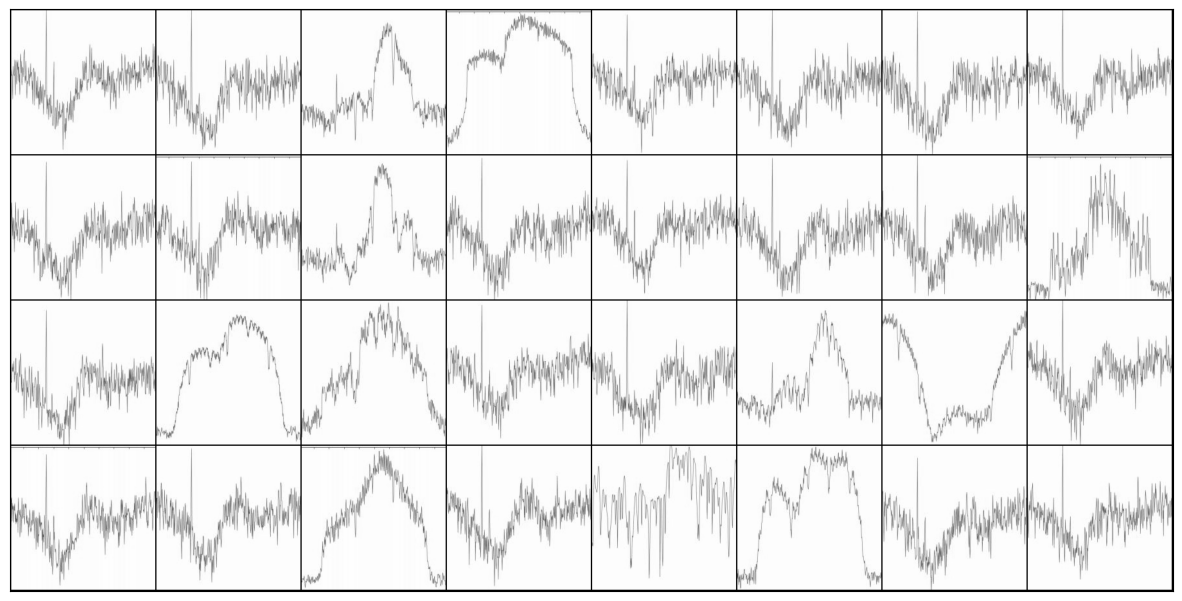

In [ ]:
show_batch(train_loader)

torch.Size([32, 1, 224, 224])


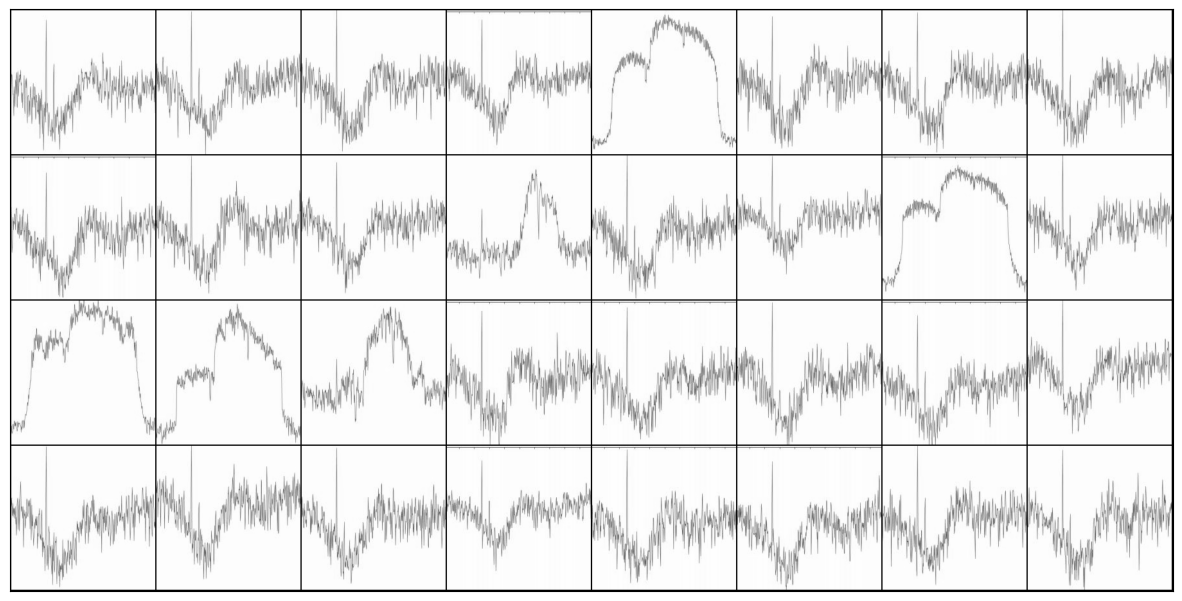

In [ ]:
show_batch(test_loader)

Описание модели:


In [ ]:
import torch.nn as nn

class Binary_signal_classification(nn.Module):
  def __init__(self):
    super(Binary_signal_classification, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.AvgPool2d(10))
    self.fc= nn.Linear(1600, 10)

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.view(x.size(0),-1) # или x = nn.Flatten()(x)
    x = self.fc(x)
    return x

In [ ]:
model=Binary_signal_classification()
model.to(device)

Binary_signal_classification(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
   

In [ ]:
! pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model,input_size=(batch_size,1,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Binary_signal_classification             [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        160
│    └─ReLU: 2-2                         [32, 16, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [32, 16, 224, 224]        32
│    └─Conv2d: 2-4                       [32, 16, 224, 224]        2,320
│    └─ReLU: 2-5                         [32, 16, 224, 224]        --
│    └─BatchNorm2d: 2-6                  [32, 16, 224, 224]        32
│    └─MaxPool2d: 2-7                    [32, 16, 112, 112]        --
├─Sequential: 1-2                        [32, 32, 56, 56]          --
│    └─Conv2d: 2-8                       [32, 32, 112, 112]        4,640
│    └─ReLU: 2-9                         [32, 32, 112, 112]        --
│    └─BatchNorm2d: 2-10                 [32, 32, 112, 112]        64
│    └─C

In [ ]:
num_classes=len(train_dataset.classes)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
!pip install pytorch-ignite --quiet

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
num_cls = 10
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=num_cls)}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(val_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  0%|          | 1/217 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 39.74 Сред. ошибка: 1.55365
Результат валидации - Эпоха: 1  Сред. точность: 36.46 Сред. ошибка: 1.62707


  0%|          | 1/217 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 41.28 Сред. ошибка: 1.47267
Результат валидации - Эпоха: 2  Сред. точность: 37.53 Сред. ошибка: 1.56130


  0%|          | 1/217 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 42.15 Сред. ошибка: 1.44057
Результат валидации - Эпоха: 3  Сред. точность: 38.74 Сред. ошибка: 1.54668


  0%|          | 1/217 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 43.71 Сред. ошибка: 1.38325
Результат валидации - Эпоха: 4  Сред. точность: 39.19 Сред. ошибка: 1.50137


  0%|          | 1/217 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 45.57 Сред. ошибка: 1.36051
Результат валидации - Эпоха: 5  Сред. точность: 38.79 Сред. ошибка: 1.50112


State:
	iteration: 1085
	epoch: 5
	epoch_length: 217
	max_epochs: 5
	output: 1.5800193548202515
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

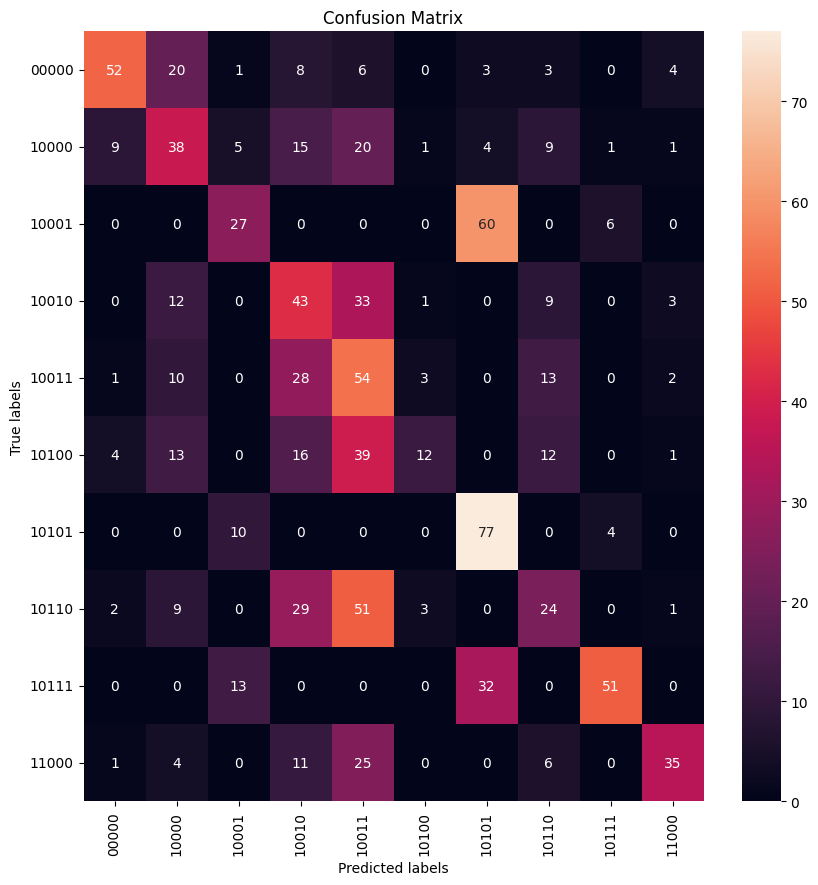

In [ ]:
trainer.run(train_loader, max_epochs=5)